In [60]:
import dgl
import dgl.data
from dgl.nn import GraphConv
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from load_graph import Load_graph, simple_dataloader

from statistics import mode
import numpy as np
import random

import time
import random
import sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes, num_layers, activation=False):
        ## 设置判断是否需要激活以及层数
        super(GCN, self).__init__()
        self.act = activation
        self.num_layers = num_layers
        # class dgl.nn.pytorch.conv.GraphConv(in_feats, out_feats, norm='both', weight=True, bias=True, activation=None, allow_zero_in_degree=False)
        self.conv1 = GraphConv(in_feats, h_feats, activation=self.act)
        self.conv2 = GraphConv(h_feats, h_feats, activation=self.act)
        self.conv3 = GraphConv(h_feats, num_classes, activation=self.act)
        
        
    def forward(self, g, in_feat):
        for i in range(self.num_layers):
            if i==0:
                h = self.conv1(g, in_feat)
                # h = F.relu(h)
            elif i==self.num_layers-1:
                h = self.conv3(g, h)
            else:
                h = self.conv2(g, h)
                # h = F.relu(h)
        return h

In [3]:
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [77]:
def train(g, model, criterion, train_mask, val_mask, test_mask):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # 记录最佳准确率
    best_val_acc = 0
    best_test_acc = 0
    
    acc_hist = []
    acc_val = []
    loss_tr = []
    loss_val = []

    features = g.ndata['feat']
    labels = g.ndata['label']
    t0 = time.time()

    for e in range(100):
        
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)
        
        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
        acc_hist.append(best_test_acc)
        acc_val.append(best_val_acc)
        
        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])
        loss_tr.append(loss)
        loss_val.append(criterion(logits[val_mask], labels[val_mask]))
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            elapsed = format_time(time.time() - t0)
            print('>>> epoch {}'.format(e))
            print('loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                loss, val_acc, best_val_acc, test_acc, best_test_acc), elapsed)
    return acc_hist, acc_val, loss_tr, loss_val

In [5]:
## ppi数据集的训练
def train2(g, model, criterion, train_mask, val_mask, test_mask):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    best_val_acc = 0
    best_test_acc = 0
    acc_hist = []
    acc_val = []
    loss_tr = []
    loss_val = []

    features = g.ndata['feat']
    labels = g.ndata['label']
    t0 = time.time()

    for e in range(100):
        # Forward
        logits = model(g, features)

        # PPI数据集
        train_acc = (logits[train_mask].ge(0.5) == labels[train_mask]).float().mean()
        val_acc = (logits[val_mask].ge(0.5) == labels[val_mask]).float().mean()
        test_acc = (logits[test_mask].ge(0.5) == labels[test_mask]).float().mean()
        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
        acc_hist.append(best_test_acc)
        acc_val.append(best_val_acc)
        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])
        loss_tr.append(loss)
        loss_val.append(criterion(logits[val_mask], labels[val_mask]))
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            elapsed = format_time(time.time() - t0)
            print('>>> epoch {}'.format(e))
            print('loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                loss, val_acc, best_val_acc, test_acc, best_test_acc), elapsed)
    return acc_hist, acc_val, loss_tr, loss_val

### cora 数据

In [48]:
# 导入数据
dataset = Load_graph('cora','node')
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [7]:
g
g.ndata['feat']

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0526, 0.0000]])

In [8]:
# 训练
criterion = F.cross_entropy
activation = F.relu
num_layers = 2
hidden_dim = 64

g = g.to('cuda')
model = GCN(g.ndata['feat'].shape[1], hidden_dim, dataset.num_classes, num_layers, activation).to('cuda')
acc, accval, loss, lossval = train(g, model, criterion, train_mask=g.ndata['train_mask'], val_mask=g.ndata['val_mask'], test_mask=g.ndata['test_mask'])

>>> epoch 0
loss: 1.946, val acc: 0.174 (best 0.174), test acc: 0.194 (best 0.194) 0:00:03
>>> epoch 5
loss: 1.843, val acc: 0.494 (best 0.494), test acc: 0.519 (best 0.519) 0:00:03
>>> epoch 10
loss: 1.671, val acc: 0.558 (best 0.558), test acc: 0.578 (best 0.578) 0:00:03
>>> epoch 15
loss: 1.447, val acc: 0.568 (best 0.568), test acc: 0.599 (best 0.599) 0:00:03
>>> epoch 20
loss: 1.209, val acc: 0.576 (best 0.576), test acc: 0.613 (best 0.614) 0:00:03
>>> epoch 25
loss: 1.003, val acc: 0.586 (best 0.586), test acc: 0.614 (best 0.614) 0:00:03
>>> epoch 30
loss: 0.851, val acc: 0.590 (best 0.590), test acc: 0.620 (best 0.614) 0:00:03
>>> epoch 35
loss: 0.749, val acc: 0.590 (best 0.594), test acc: 0.612 (best 0.614) 0:00:03
>>> epoch 40
loss: 0.682, val acc: 0.594 (best 0.594), test acc: 0.609 (best 0.614) 0:00:03
>>> epoch 45
loss: 0.640, val acc: 0.590 (best 0.594), test acc: 0.605 (best 0.614) 0:00:03
>>> epoch 50
loss: 0.613, val acc: 0.590 (best 0.594), test acc: 0.594 (best 0.614

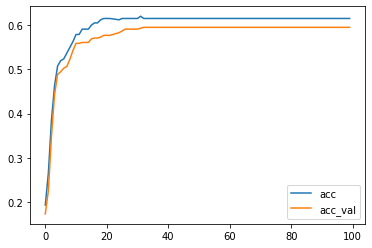

In [9]:
plt.plot(acc,label='acc')
plt.plot(accval,label='acc_val')
plt.legend()
plt.savefig('coraacc.pdf')

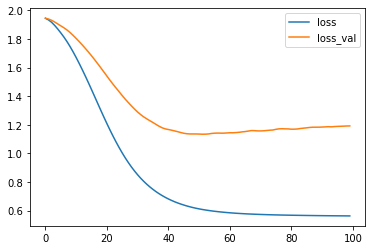

In [10]:
plt.plot(loss,label='loss')
plt.plot(lossval,label='loss_val')
plt.legend()
plt.savefig('coraloss.pdf')

>>> epoch 0
loss: 4.159, val acc: 0.026 (best 0.026), test acc: 0.020 (best 0.020) 0:00:00
>>> epoch 5
loss: 4.077, val acc: 0.388 (best 0.388), test acc: 0.374 (best 0.374) 0:00:00
>>> epoch 10
loss: 3.988, val acc: 0.470 (best 0.470), test acc: 0.464 (best 0.464) 0:00:00
>>> epoch 15
loss: 3.899, val acc: 0.516 (best 0.516), test acc: 0.526 (best 0.526) 0:00:00
>>> epoch 20
loss: 3.811, val acc: 0.554 (best 0.554), test acc: 0.551 (best 0.551) 0:00:00
>>> epoch 25
loss: 3.723, val acc: 0.550 (best 0.556), test acc: 0.562 (best 0.556) 0:00:00
>>> epoch 30
loss: 3.637, val acc: 0.560 (best 0.560), test acc: 0.573 (best 0.573) 0:00:00
>>> epoch 35
loss: 3.551, val acc: 0.564 (best 0.564), test acc: 0.582 (best 0.582) 0:00:00
>>> epoch 40
loss: 3.467, val acc: 0.576 (best 0.576), test acc: 0.587 (best 0.585) 0:00:00
>>> epoch 45
loss: 3.383, val acc: 0.580 (best 0.580), test acc: 0.589 (best 0.589) 0:00:00
>>> epoch 50
loss: 3.301, val acc: 0.576 (best 0.580), test acc: 0.599 (best 0.589

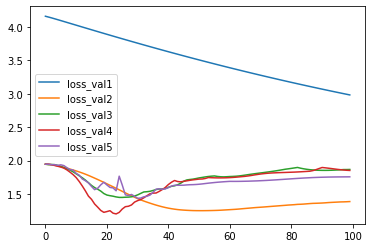

In [11]:
for i in range(1,6):
    model = GCN(g.ndata['feat'].shape[1], hidden_dim, dataset.num_classes, i, activation).to('cuda')
    acc, accval, loss, lossval = train(g, model, criterion, train_mask=g.ndata['train_mask'], val_mask=g.ndata['val_mask'], test_mask=g.ndata['test_mask'])
    plt.plot(lossval,label='loss_val'+str(i))
plt.legend()
plt.savefig('coraloss2.pdf')

>>> epoch 0
loss: 1.946, val acc: 0.164 (best 0.164), test acc: 0.141 (best 0.141) 0:00:00
>>> epoch 5
loss: 1.915, val acc: 0.366 (best 0.410), test acc: 0.371 (best 0.421) 0:00:00
>>> epoch 10
loss: 1.870, val acc: 0.378 (best 0.410), test acc: 0.383 (best 0.421) 0:00:00
>>> epoch 15
loss: 1.813, val acc: 0.448 (best 0.448), test acc: 0.456 (best 0.456) 0:00:00
>>> epoch 20
loss: 1.745, val acc: 0.532 (best 0.532), test acc: 0.529 (best 0.529) 0:00:00
>>> epoch 25
loss: 1.665, val acc: 0.612 (best 0.612), test acc: 0.594 (best 0.594) 0:00:00
>>> epoch 30
loss: 1.572, val acc: 0.648 (best 0.652), test acc: 0.653 (best 0.637) 0:00:00
>>> epoch 35
loss: 1.469, val acc: 0.662 (best 0.662), test acc: 0.684 (best 0.684) 0:00:00
>>> epoch 40
loss: 1.356, val acc: 0.690 (best 0.690), test acc: 0.714 (best 0.710) 0:00:00
>>> epoch 45
loss: 1.237, val acc: 0.690 (best 0.690), test acc: 0.730 (best 0.710) 0:00:00
>>> epoch 50
loss: 1.115, val acc: 0.704 (best 0.704), test acc: 0.740 (best 0.739

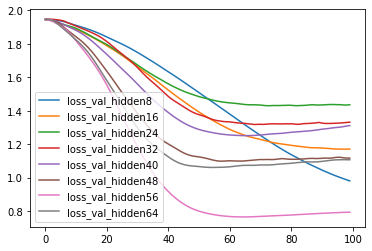

In [12]:
g = g.to('cuda')
for i in range(8,65,8):
    model = GCN(g.ndata['feat'].shape[1], i, dataset.num_classes, 2, activation).to('cuda')
    acc, accval, loss, lossval = train(g, model, criterion, train_mask=g.ndata['train_mask'], val_mask=g.ndata['val_mask'], test_mask=g.ndata['test_mask'])
    plt.plot(lossval,label='loss_val_hidden'+str(i))
plt.legend()
plt.savefig('coraloss3.pdf')

>>> epoch 0
loss: 1.946, val acc: 0.118 (best 0.118), test acc: 0.111 (best 0.111) 0:00:00
>>> epoch 5
loss: 1.921, val acc: 0.374 (best 0.374), test acc: 0.348 (best 0.348) 0:00:00
>>> epoch 10
loss: 1.882, val acc: 0.374 (best 0.376), test acc: 0.360 (best 0.353) 0:00:00
>>> epoch 15
loss: 1.835, val acc: 0.384 (best 0.384), test acc: 0.372 (best 0.372) 0:00:00
>>> epoch 20
loss: 1.780, val acc: 0.386 (best 0.386), test acc: 0.381 (best 0.381) 0:00:00
>>> epoch 25
loss: 1.717, val acc: 0.406 (best 0.406), test acc: 0.387 (best 0.386) 0:00:00
>>> epoch 30
loss: 1.648, val acc: 0.412 (best 0.412), test acc: 0.396 (best 0.394) 0:00:00
>>> epoch 35
loss: 1.574, val acc: 0.418 (best 0.418), test acc: 0.405 (best 0.405) 0:00:00
>>> epoch 40
loss: 1.498, val acc: 0.416 (best 0.420), test acc: 0.408 (best 0.407) 0:00:00
>>> epoch 45
loss: 1.422, val acc: 0.418 (best 0.420), test acc: 0.410 (best 0.407) 0:00:00
>>> epoch 50
loss: 1.349, val acc: 0.420 (best 0.420), test acc: 0.412 (best 0.407

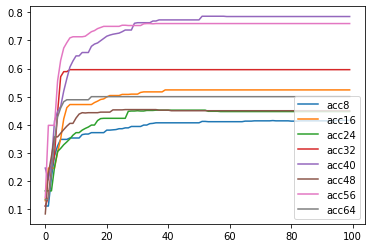

In [22]:
g = g.to('cuda')
for i in range(8,65,8):
    model = GCN(g.ndata['feat'].shape[1], i, dataset.num_classes, 2, activation).to('cuda')
    acc, accval, loss, lossval = train(g, model, criterion, train_mask=g.ndata['train_mask'], val_mask=g.ndata['val_mask'], test_mask=g.ndata['test_mask'])
    plt.plot(acc,label='acc'+str(i))
plt.legend()
plt.savefig('coraloss4.pdf')

In [55]:
## 综合来看，隐藏神经元选56的效果最好，层数选2层最好
model = GCN(g.ndata['feat'].shape[1], 56, dataset.num_classes, 2, activation)
acc, accval, loss, lossval = train(g, model, criterion, train_mask=g.ndata['train_mask'], val_mask=g.ndata['val_mask'], test_mask=g.ndata['test_mask'])
torch.max(torch.tensor(acc)),torch.min(torch.tensor(lossval))

>>> epoch 0
loss: 1.946, val acc: 0.092 (best 0.092), test acc: 0.088 (best 0.088) 0:00:00
>>> epoch 5
loss: 1.877, val acc: 0.338 (best 0.338), test acc: 0.396 (best 0.396) 0:00:00
>>> epoch 10
loss: 1.736, val acc: 0.482 (best 0.482), test acc: 0.535 (best 0.535) 0:00:00
>>> epoch 15
loss: 1.538, val acc: 0.584 (best 0.584), test acc: 0.608 (best 0.608) 0:00:00
>>> epoch 20
loss: 1.299, val acc: 0.612 (best 0.612), test acc: 0.633 (best 0.633) 0:00:00
>>> epoch 25
loss: 1.049, val acc: 0.624 (best 0.624), test acc: 0.662 (best 0.656) 0:00:00
>>> epoch 30
loss: 0.827, val acc: 0.630 (best 0.630), test acc: 0.669 (best 0.670) 0:00:01
>>> epoch 35
loss: 0.653, val acc: 0.640 (best 0.640), test acc: 0.672 (best 0.672) 0:00:01
>>> epoch 40
loss: 0.529, val acc: 0.638 (best 0.642), test acc: 0.673 (best 0.674) 0:00:01
>>> epoch 45
loss: 0.447, val acc: 0.640 (best 0.642), test acc: 0.676 (best 0.674) 0:00:01
>>> epoch 50
loss: 0.393, val acc: 0.638 (best 0.642), test acc: 0.675 (best 0.674

(tensor(0.6740), tensor(1.0768))

### citeseer 数据

In [65]:
# 导入数据
dataset = Load_graph('citeseer','node')
g = dataset[0]
criterion = F.cross_entropy
activation = F.relu
num_layers = 2
hidden_dim = 56

  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [66]:
g = g.to('cuda')
model = GCN(g.ndata['feat'].shape[1], hidden_dim, dataset.num_classes, num_layers, activation).to('cuda')
acc, accval, loss, lossval = train(g, model, criterion, train_mask=g.ndata['train_mask'], val_mask=g.ndata['val_mask'], test_mask=g.ndata['test_mask'])

>>> epoch 0
loss: 1.792, val acc: 0.106 (best 0.106), test acc: 0.103 (best 0.103) 0:00:00
>>> epoch 5
loss: 1.693, val acc: 0.338 (best 0.338), test acc: 0.338 (best 0.338) 0:00:00
>>> epoch 10
loss: 1.497, val acc: 0.504 (best 0.504), test acc: 0.477 (best 0.477) 0:00:00
>>> epoch 15
loss: 1.227, val acc: 0.624 (best 0.624), test acc: 0.614 (best 0.614) 0:00:00
>>> epoch 20
loss: 0.914, val acc: 0.656 (best 0.656), test acc: 0.652 (best 0.652) 0:00:00
>>> epoch 25
loss: 0.619, val acc: 0.670 (best 0.670), test acc: 0.657 (best 0.657) 0:00:00
>>> epoch 30
loss: 0.392, val acc: 0.660 (best 0.670), test acc: 0.650 (best 0.657) 0:00:00
>>> epoch 35
loss: 0.242, val acc: 0.656 (best 0.670), test acc: 0.641 (best 0.657) 0:00:00
>>> epoch 40
loss: 0.152, val acc: 0.654 (best 0.670), test acc: 0.632 (best 0.657) 0:00:00
>>> epoch 45
loss: 0.098, val acc: 0.646 (best 0.670), test acc: 0.626 (best 0.657) 0:00:00
>>> epoch 50
loss: 0.066, val acc: 0.642 (best 0.670), test acc: 0.624 (best 0.657

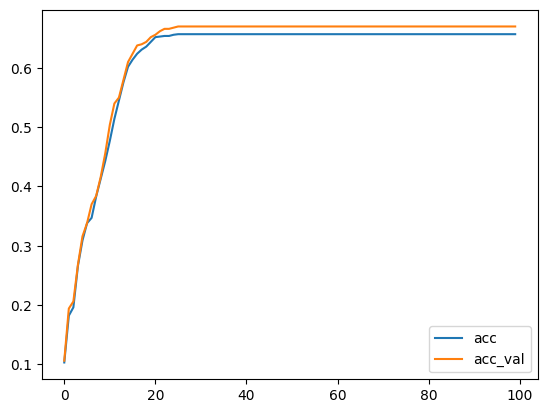

In [67]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.plot(acc,label='acc')
plt.plot(accval,label='acc_val')

plt.legend()
plt.savefig('citeacc.pdf')

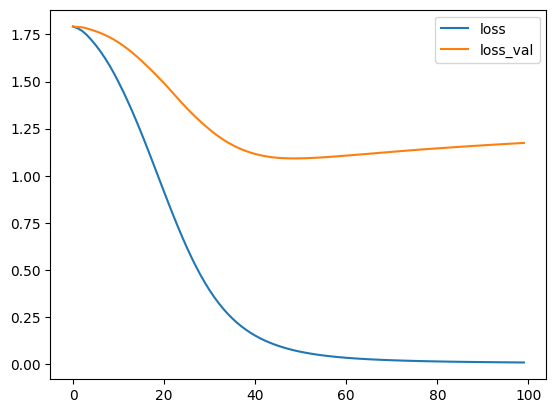

In [68]:
plt.plot(loss,label='loss')
plt.plot(lossval,label='loss_val')

plt.legend()
plt.savefig('citeloss.pdf')

In [69]:
torch.max(torch.tensor(acc)),torch.min(torch.tensor(lossval))

(tensor(0.6570), tensor(1.0921))

### ppi 数据

In [24]:
# 导入数据
dataset = Load_graph('ppi', 'node')
loader = simple_dataloader(dataset=dataset)
# 训练
# criterion = F.mse_loss
criterion = F.cross_entropy
activation = F.relu
num_layers = 2
hidden_dim = 56

In [30]:
# i = 0
acc_hist = []
loss_val = []

# plt.rcParams.update({'figure.figsize':(20,40), 'figure.dpi':300})
for g in loader:
    i += 1
    # 随机取下标作为训练、测试、验证集
    # g = g.to('cuda')
    train_index = np.random.choice(np.arange(int(0.5*g.num_nodes())), size=int(0.2*g.num_nodes()), replace=False)
    val_index = np.delete(np.arange(g.num_nodes()), train_index)
    test_index = np.arange(int(0.5*g.num_nodes()), g.num_nodes())
    # if hasattr(torch.cuda, 'empty_cache'):
	#     torch.cuda.empty_cache()
    model = GCN(g.ndata['feat'].shape[1], hidden_dim, g.ndata['label'].shape[1], num_layers, activation)
    acc, accval, loss, lossval = train2(g, model, criterion, train_mask=train_index, val_mask=val_index, test_mask=test_index)
    # plt.plot(acc,label='acc'+str(i))
    # plt.plot(accval,label='acc_val'+str(i))
    # plt.plot(loss,label='loss'+str(i))
    # plt.plot(lossval,label='loss_val'+str(i))
    acc_hist.append(max(acc))
    loss_val.append(min(lossval))
# plt.savefig('ppi.pdf')
# plt.legend()

>>> epoch 0
loss: 181.291, val acc: 0.679 (best 0.679), test acc: 0.681 (best 0.681) 0:00:00
>>> epoch 5
loss: 179.292, val acc: 0.689 (best 0.689), test acc: 0.690 (best 0.690) 0:00:00
>>> epoch 10
loss: 177.898, val acc: 0.723 (best 0.723), test acc: 0.723 (best 0.723) 0:00:00
>>> epoch 15
loss: 177.450, val acc: 0.717 (best 0.724), test acc: 0.718 (best 0.724) 0:00:00
>>> epoch 20
loss: 176.844, val acc: 0.716 (best 0.724), test acc: 0.717 (best 0.724) 0:00:00
>>> epoch 25
loss: 176.359, val acc: 0.718 (best 0.724), test acc: 0.719 (best 0.724) 0:00:00
>>> epoch 30
loss: 175.957, val acc: 0.717 (best 0.724), test acc: 0.717 (best 0.724) 0:00:00
>>> epoch 35
loss: 175.606, val acc: 0.713 (best 0.724), test acc: 0.714 (best 0.724) 0:00:00
>>> epoch 40
loss: 175.286, val acc: 0.712 (best 0.724), test acc: 0.713 (best 0.724) 0:00:01
>>> epoch 45
loss: 174.994, val acc: 0.713 (best 0.724), test acc: 0.714 (best 0.724) 0:00:01
>>> epoch 50
loss: 174.724, val acc: 0.713 (best 0.724), test 

In [47]:
torch.mean(torch.tensor(acc_hist)),torch.mean(torch.tensor(loss_val))

(tensor(0.7271), tensor(178.2713))

## 进一步分析

In [75]:
## 重新修改模型，加入PairNorm（上面已经构件好才发现要分析不想改上面了www）

class PairNorm(nn.Module):
    def __init__(self, scale=1):
        super(PairNorm, self).__init__()
        self.scale = scale


    def forward(self, x):
        col_mean = x.mean(dim=0)
        rownorm_individual = (1e-6 + x.pow(2).sum(dim=1, keepdim=True)).sqrt()
        x = self.scale * x / rownorm_individual - col_mean
        return x

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes, num_layers, activation, pair_norm):
        super(GCN, self).__init__()
        ## 设置判断是否需要激活以及层数
        super(GCN, self).__init__()
        self.act = activation
        self.num_layers = num_layers
        self.pair_norm = pair_norm
        # class dgl.nn.pytorch.conv.GraphConv(in_feats, out_feats, norm='both', weight=True, bias=True, activation=None, allow_zero_in_degree=False)
        self.conv1 = GraphConv(in_feats, h_feats, activation=self.act)
        self.conv2 = GraphConv(h_feats, h_feats, activation=self.act)
        self.conv3 = GraphConv(h_feats, num_classes, activation=self.act)
        
    def forward(self, g, in_feat):
        for i in range(self.num_layers):
            if i==0:
                h = self.conv1(g, in_feat)
                if self.pair_norm:
                    h = PairNorm()(h)
            elif i==self.num_layers-1:
                h = self.conv3(g, h)
            else:
                h = self.conv2(g, h)
                if self.pair_norm:
                    h = PairNorm()(h)
        return h

In [97]:

criterion = F.cross_entropy
activation = F.relu
activation2 = F.elu
activation3 = F.leaky_relu
num_layers = 2
hidden_dim = 56
pair_norm1 = False
pair_norm2 = True

### cora 数据

In [98]:
dataset = Load_graph('cora','node')
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
>>> epoch 0
loss: 1.945, val acc: 0.126 (best 0.126), test acc: 0.120 (best 0.120) 0:00:00
>>> epoch 5
loss: 1.780, val acc: 0.430 (best 0.430), test acc: 0.427 (best 0.427) 0:00:00
>>> epoch 10
loss: 1.551, val acc: 0.744 (best 0.744), test acc: 0.744 (best 0.744) 0:00:00
>>> epoch 15
loss: 1.266, val acc: 0.746 (best 0.752), test acc: 0.749 (best 0.758) 0:00:00
>>> epoch 20
loss: 0.958, val acc: 0.770 (best 0.770), test acc: 0.761 (best 0.761) 0:00:00
>>> epoch 25
loss: 0.674, val acc: 0.784 (best 0.784), test acc: 0.768 (best 0.768) 0:00:00
>>> epoch 30
loss: 0.451, val acc: 0.790 (best 0.790), test acc: 0.778 (best 0.778) 0:00:01
>>> epoch 35
loss: 0.296, val acc: 0.798 (best 0.798), test acc: 0.783 (best 0.782) 0:00:01
>>> epoch 40
loss: 0.196, val acc: 0.794 (best 0.798), test acc: 0.786 (best 0.782) 

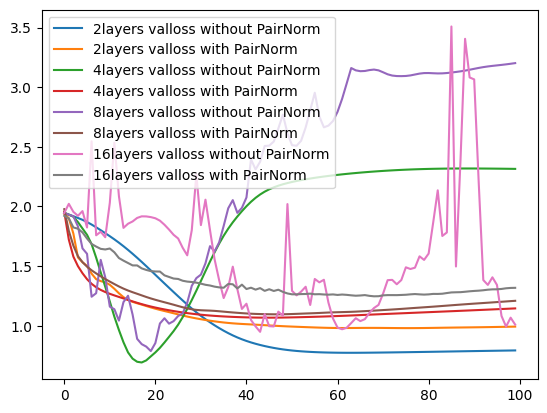

In [81]:
## 由于PairNorm在深层才有作用，选2,4,8,16层
for _,i in enumerate([2,4,8,16]):
    model = GCN(g.ndata['feat'].shape[1], hidden_dim, dataset.num_classes, i, activation, pair_norm1)
    acc, accval, loss, lossval = train(g, model, criterion, train_mask=g.ndata['train_mask'], val_mask=g.ndata['val_mask'], test_mask=g.ndata['test_mask'])
    plt.plot(lossval,label=str(i)+'layers valloss without PairNorm')
    model = GCN(g.ndata['feat'].shape[1], hidden_dim, dataset.num_classes, i, activation, pair_norm2)
    acc, accval, loss, lossval = train(g, model, criterion, train_mask=g.ndata['train_mask'], val_mask=g.ndata['val_mask'], test_mask=g.ndata['test_mask'])
    plt.plot(lossval,label=str(i)+'layers valloss with PairNorm')
plt.legend()
plt.savefig('corapair.pdf')

>>> epoch 0
loss: 1.946, val acc: 0.092 (best 0.092), test acc: 0.101 (best 0.101) 0:00:00
>>> epoch 5
loss: 1.876, val acc: 0.350 (best 0.360), test acc: 0.375 (best 0.378) 0:00:00
>>> epoch 10
loss: 1.758, val acc: 0.372 (best 0.372), test acc: 0.374 (best 0.374) 0:00:00
>>> epoch 15
loss: 1.604, val acc: 0.390 (best 0.390), test acc: 0.398 (best 0.398) 0:00:00
>>> epoch 20
loss: 1.430, val acc: 0.394 (best 0.394), test acc: 0.400 (best 0.400) 0:00:00
>>> epoch 25
loss: 1.263, val acc: 0.400 (best 0.402), test acc: 0.408 (best 0.407) 0:00:00
>>> epoch 30
loss: 1.127, val acc: 0.406 (best 0.406), test acc: 0.410 (best 0.410) 0:00:01
>>> epoch 35
loss: 1.029, val acc: 0.408 (best 0.408), test acc: 0.410 (best 0.410) 0:00:01
>>> epoch 40
loss: 0.964, val acc: 0.404 (best 0.408), test acc: 0.410 (best 0.410) 0:00:01
>>> epoch 45
loss: 0.922, val acc: 0.406 (best 0.408), test acc: 0.405 (best 0.410) 0:00:01
>>> epoch 50
loss: 0.895, val acc: 0.404 (best 0.408), test acc: 0.403 (best 0.410

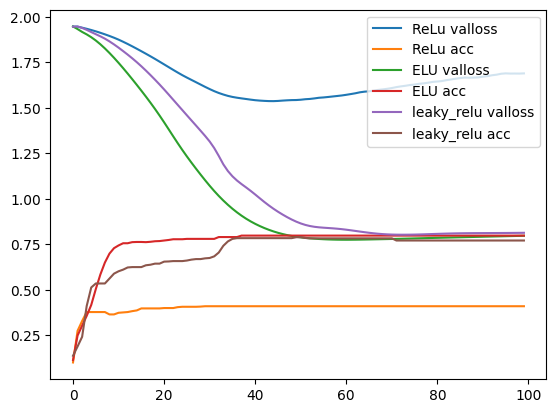

In [100]:
## 看出确实层数增大的时候PairNorm的效果明显，但2层的效果还是很好的。再比较不同的激活函数：
model = GCN(g.ndata['feat'].shape[1], hidden_dim, dataset.num_classes, 2, activation, pair_norm1)
acc, accval, loss, lossval = train(g, model, criterion, train_mask=g.ndata['train_mask'], val_mask=g.ndata['val_mask'], test_mask=g.ndata['test_mask'])
plt.plot(lossval,label='ReLu valloss')
plt.plot(acc,label='ReLu acc')
model = GCN(g.ndata['feat'].shape[1], hidden_dim, dataset.num_classes, 2, activation2, pair_norm1)
acc, accval, loss, lossval = train(g, model, criterion, train_mask=g.ndata['train_mask'], val_mask=g.ndata['val_mask'], test_mask=g.ndata['test_mask'])
plt.plot(lossval,label='ELU valloss')
plt.plot(acc,label='ELU acc')
model = GCN(g.ndata['feat'].shape[1], hidden_dim, dataset.num_classes, 2, activation3, pair_norm1)
acc, accval, loss, lossval = train(g, model, criterion, train_mask=g.ndata['train_mask'], val_mask=g.ndata['val_mask'], test_mask=g.ndata['test_mask'])
plt.plot(lossval,label='leaky_relu valloss')
plt.plot(acc,label='leaky_relu acc')
plt.legend()
plt.savefig('coraELU.pdf')

>>> epoch 0
loss: 177.875, val acc: 0.702 (best 0.702), test acc: 0.702 (best 0.702) 0:00:00
>>> epoch 5
loss: 176.148, val acc: 0.708 (best 0.708), test acc: 0.708 (best 0.708) 0:00:00
>>> epoch 10
loss: 175.096, val acc: 0.732 (best 0.732), test acc: 0.732 (best 0.732) 0:00:00
>>> epoch 15
loss: 174.754, val acc: 0.729 (best 0.732), test acc: 0.730 (best 0.732) 0:00:00
>>> epoch 20
loss: 174.191, val acc: 0.732 (best 0.732), test acc: 0.734 (best 0.734) 0:00:00
>>> epoch 25
loss: 173.839, val acc: 0.734 (best 0.734), test acc: 0.735 (best 0.735) 0:00:01
>>> epoch 30
loss: 173.610, val acc: 0.733 (best 0.734), test acc: 0.735 (best 0.735) 0:00:01
>>> epoch 35
loss: 173.346, val acc: 0.732 (best 0.734), test acc: 0.734 (best 0.735) 0:00:01
>>> epoch 40
loss: 173.104, val acc: 0.732 (best 0.734), test acc: 0.734 (best 0.735) 0:00:01
>>> epoch 45
loss: 172.896, val acc: 0.732 (best 0.734), test acc: 0.734 (best 0.735) 0:00:01
>>> epoch 50
loss: 172.687, val acc: 0.731 (best 0.734), test 

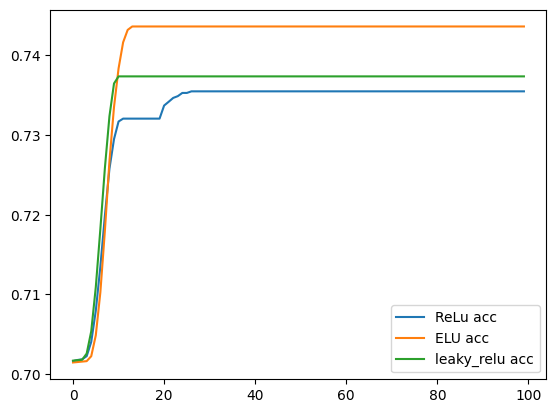

In [101]:
## 发现elu比relu明显好一些，由于citeseer和cora数据集的形式一样，用ppi的一个再验证一下
# 导入数据
dataset = Load_graph('ppi', 'node')
loader = simple_dataloader(dataset=dataset)
for g in loader:

    train_index = np.random.choice(np.arange(int(0.5*g.num_nodes())), size=int(0.2*g.num_nodes()), replace=False)
    val_index = np.delete(np.arange(g.num_nodes()), train_index)
    test_index = np.arange(int(0.5*g.num_nodes()), g.num_nodes())

    model = GCN(g.ndata['feat'].shape[1], hidden_dim, g.ndata['label'].shape[1], num_layers, activation, pair_norm1)
    acc, accval, loss, lossval = train2(g, model, criterion, train_mask=train_index, val_mask=val_index, test_mask=test_index)
    # plt.plot(lossval,label='ReLu valloss')
    plt.plot(acc,label='ReLu acc')
    
    model = GCN(g.ndata['feat'].shape[1], hidden_dim, g.ndata['label'].shape[1], num_layers, activation2, pair_norm1)
    acc, accval, loss, lossval = train2(g, model, criterion, train_mask=train_index, val_mask=val_index, test_mask=test_index)
    # plt.plot(lossval,label='ELU valloss')
    plt.plot(acc,label='ELU acc')
    
    model = GCN(g.ndata['feat'].shape[1], hidden_dim, g.ndata['label'].shape[1], num_layers, activation3, pair_norm1)
    acc, accval, loss, lossval = train2(g, model, criterion, train_mask=train_index, val_mask=val_index, test_mask=test_index)
    # plt.plot(lossval,label='leaky_relu valloss')
    plt.plot(acc,label='leaky_relu acc')
    break   
plt.legend()
plt.savefig('ppiELU.pdf')